# 1- Import Libraries

In [178]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.26.3
1.11.4
0.7.2


# 2- Loading Dataset

In [179]:
import os
import pandas as pd

rating_file_path= '/Users/kenny_jung/aiffel/data/recommendata_iu/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [180]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path= '/Users/kenny_jung/aiffel/data/recommendata_iu/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 3- Preprocessing

In [181]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [182]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [183]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [184]:
ratings

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [185]:
ratings = pd.merge(ratings, movies, on='movie_id', how='left')
ratings

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),Drama|War
836474,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
836476,6040,1096,4,956715648,Sophie's Choice (1982),Drama


In [186]:
movie_matrix = ratings[['user_id', 'title', 'counts']]


In [187]:
movie_matrix

,user_id,title,counts
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,1,James and the Giant Peach (1996),3
2,1,My Fair Lady (1964),3
3,1,Erin Brockovich (2000),4
4,1,"Bug's Life, A (1998)",5
...,...,...,...
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4


# 4- EDA

In [188]:
# 유저 수
movie_matrix['user_id'].nunique()

6039

In [189]:
# 영화 수
movie_matrix['title'].nunique()

3628

In [190]:
# 인기 많은 영화
movie_count = movie_matrix.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

# 5- Add My Favorite

In [191]:
my_favorite = ['Matrix, The (1999)', 
               'Back to the Future (1985)',
               'Star Wars: Episode VI - Return of the Jedi (1983)',
               'Godfather: Part III, The (1990)']

my_favorite

['Matrix, The (1999)',
 'Back to the Future (1985)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Godfather: Part III, The (1990)']

In [192]:
my_movielist = pd.DataFrame({'user_id': ['kenny']*4, 'title': my_favorite, 'counts':[5]*4})
my_movielist

,user_id,title,counts
0,kenny,"Matrix, The (1999)",5
1,kenny,Back to the Future (1985),5
2,kenny,Star Wars: Episode VI - Return of the Jedi (1983),5
3,kenny,"Godfather: Part III, The (1990)",5


In [193]:
if not movie_matrix.isin({'user_id':['kenny']})['user_id'].any():  
    movie_matrix = pd.concat([movie_matrix, my_movielist])                         

movie_matrix.tail(10)  

,user_id,title,counts
836472,6040,Reservoir Dogs (1992),4
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4
0,kenny,"Matrix, The (1999)",5
1,kenny,Back to the Future (1985),5
2,kenny,Star Wars: Episode VI - Return of the Jedi (1983),5
3,kenny,"Godfather: Part III, The (1990)",5


# 6- Indexing

In [194]:
user_unique = movie_matrix['user_id'].unique()
title_unique = movie_matrix['title'].unique()

user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(title_unique)}

In [195]:
print(user_to_idx['kenny'])
print(movie_to_idx['Matrix, The (1999)'])

6039
124


In [197]:
# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = movie_matrix['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(movie_matrix):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    movie_matrix['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = movie_matrix['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(movie_matrix):
    print('movie column indexing OK!!')
    movie_matrix['title'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

movie_matrix

user_id column indexing Fail!!
movie column indexing OK!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
836477,6038,26,4
0,6039,124,5
1,6039,22,5
2,6039,64,5


# 7- CSR Matrix

In [198]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = movie_matrix['user_id'].nunique()
num_movie = movie_matrix['title'].nunique()

csr_data = csr_matrix((movie_matrix.counts, (movie_matrix.user_id, movie_matrix.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836482 stored elements in Compressed Sparse Row format>

# 8- Model Factorization Model Training

In [199]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1' # 병렬처리를 하지 않도록 설정
os.environ['KMP_DUPLICATE_LIB_OK']='True' # 병렬처리를 하지 않도록 설정
os.environ['MKL_NUM_THREADS']='1' # 병렬처리를 하지 않도록 설정

In [238]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100,           # 유저와 아이템의 벡터를 100차원으로 만듭니다.
                                    regularization=0.01,   # 과적합을 방지하기 위해 정규화 값을 0.01로 설정
                                    use_gpu=False,         # GPU를 사용 여부
                                    iterations=15,         # epochs와 같은 의미입니다. 모델 학습 반복 횟수입니다.
                                    dtype=np.float32)      # 데이터 타입

ValueError: No CUDA extension has been built, can't train on GPU.

In [201]:
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836482 stored elements in Compressed Sparse Row format>

In [202]:
als_model.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

# 9- Validation

In [203]:
print(type(als_model))

<class 'implicit.cpu.als.AlternatingLeastSquares'>


In [204]:
als_model.user_factors.shape

(6040, 100)

In [206]:
als_model.item_factors.shape

(3628, 100)

In [209]:
user_to_idx['kenny']

6039

In [210]:
movie_to_idx['Matrix, The (1999)']

124

In [213]:
v1 = als_model.user_factors[user_to_idx['kenny']]
v1

array([ 0.2273347 ,  0.4580689 , -0.45386502,  0.36283094,  0.1535027 ,
       -0.6096171 , -0.711843  , -0.01710669,  0.35692173, -0.54949135,
       -0.35394698,  0.20360039, -1.1687676 , -0.8525098 , -0.33513677,
        0.09739704, -1.0103436 , -0.18702549, -0.09429178, -0.432131  ,
        0.61036116,  0.6584214 ,  0.08965676, -0.4627674 ,  0.77615213,
        0.8161415 , -0.23712724,  0.25865462,  0.14394805, -0.57072014,
       -0.749883  ,  0.23935032, -0.09192725,  0.46425545,  0.05870307,
        0.4353818 , -0.24939445, -0.32601395, -0.1269931 ,  0.62536573,
        0.99975646,  0.4377293 ,  0.7231397 ,  0.11078191, -0.27287596,
       -0.85868895, -0.32789856, -0.12185658, -0.04867122, -0.00767137,
        0.56876206,  0.18336704,  0.56051356, -0.09735285, -0.08633439,
        0.14584099, -0.29834828,  0.07239037, -0.33706415, -0.630336  ,
        0.3466366 ,  0.8366249 ,  0.00492233,  0.5601925 ,  0.44981042,
       -0.38961065, -0.11506446, -0.1876509 , -0.10164572,  0.40

In [218]:
v2 = als_model.item_factors[movie_to_idx['Matrix, The (1999)']]
v2

array([-5.3129666e-03, -3.8258103e-03,  1.9224651e-02, -8.3424356e-03,
        3.6666840e-03, -7.5994241e-03, -1.6356716e-02,  2.2032894e-02,
        2.5394322e-02,  1.4124553e-02,  1.1639928e-02,  1.9058293e-02,
       -2.6545888e-02, -1.0409918e-02, -6.5315957e-03, -1.0367913e-02,
       -2.6583120e-03,  9.2527540e-03, -1.3894880e-02, -2.0595508e-02,
       -8.3706686e-03,  1.6826922e-02,  4.6094893e-03, -2.6535541e-03,
        2.2349343e-02,  2.6614213e-02, -9.4618443e-03,  2.0972367e-02,
        9.5009143e-03, -2.4618952e-02, -1.0916680e-02,  1.8275779e-02,
        2.0836534e-02,  2.1935040e-03,  5.0002397e-03,  3.7444912e-02,
        1.0569731e-02, -2.7187055e-03, -8.2465699e-03,  4.2927101e-02,
        3.3059284e-02,  1.5778336e-03,  4.6475925e-03,  4.6933112e-03,
        9.6395528e-03, -1.1375753e-02,  3.5668869e-05, -1.5143387e-02,
        1.0312651e-02, -3.2066088e-03, -7.9169322e-04,  1.1466945e-02,
        1.2504419e-02, -1.2977995e-02,  3.7643205e-02,  1.7957281e-02,
      

In [223]:
v3 = als_model.item_factors[movie_to_idx['Back to the Future (1985)']]

In [224]:
v4 = als_model.item_factors[movie_to_idx['Toy Story (1995)']]

In [221]:
np.dot(v1, v2)

0.43374157

In [222]:
np.dot(v1, v3)

0.5648589

In [225]:
np.dot(v1, v4)

0.15875658

# 10- Similar Movie

In [228]:
favorite_movie = 'Matrix, The (1999)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=10)
similar_movie

(array([124,  92,  62, 141, 200, 107, 145, 375, 175, 317], dtype=int32),
 array([1.0000001 , 0.77955675, 0.7002699 , 0.59259933, 0.58665067,
        0.57076126, 0.5669755 , 0.53628206, 0.5188777 , 0.4891881 ],
       dtype=float32))

In [229]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[idx] for idx in similar_movie[0]]

['Matrix, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Fugitive, The (1993)',
 'Terminator, The (1984)',
 'Jurassic Park (1993)',
 'Fifth Element, The (1997)',
 'Face/Off (1997)',
 'Men in Black (1997)',
 'Twelve Monkeys (1995)']

In [230]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[idx] for idx in similar_movie[0]]
    return similar_movie

In [231]:
get_similar_movie('Toy Story (1995)')

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 'Aladdin (1992)',
 "Bug's Life, A (1998)",
 'Babe (1995)',
 'Groundhog Day (1993)',
 'Lion King, The (1994)',
 'Pleasantville (1998)',
 'Beauty and the Beast (1991)',
 "There's Something About Mary (1998)"]

# 11- Recommend Movie

In [232]:
user = user_to_idx['kenny']
print(user)

6039


In [234]:
user = user_to_idx['kenny']
user_items = csr_data[user]
# recommend에서는 user*item CSR Matrix를 받습니다.
user_items = csr_data[user]
movie_recommended = als_model.recommend(user, user_items, N=20, filter_already_liked_items=True)
movie_recommended

(array([117,  44, 607, 380,  60,  92, 107, 160, 120, 175, 200, 602,  48,
         38,  62,   5,  26, 550, 332, 193], dtype=int32),
 array([0.5531369 , 0.53280455, 0.40466207, 0.37684715, 0.37082905,
        0.340251  , 0.30809537, 0.29202098, 0.28544715, 0.28191355,
        0.28157997, 0.23219648, 0.22313337, 0.21616198, 0.19895658,
        0.19550289, 0.18342243, 0.17930835, 0.17528215, 0.17488347],
       dtype=float32))

In [237]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[idx] for idx in movie_recommended[0]]

['Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Godfather, The (1972)',
 'Godfather: Part II, The (1974)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Jurassic Park (1993)',
 'Forrest Gump (1994)',
 'Raiders of the Lost Ark (1981)',
 'Men in Black (1997)',
 'Terminator, The (1984)',
 '2001: A Space Odyssey (1968)',
 'Saving Private Ryan (1998)',
 'Sixth Sense, The (1999)',
 'Total Recall (1990)',
 'Princess Bride, The (1987)',
 'E.T. the Extra-Terrestrial (1982)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Moonstruck (1987)',
 'Alien (1979)']

# 12- Retrospective

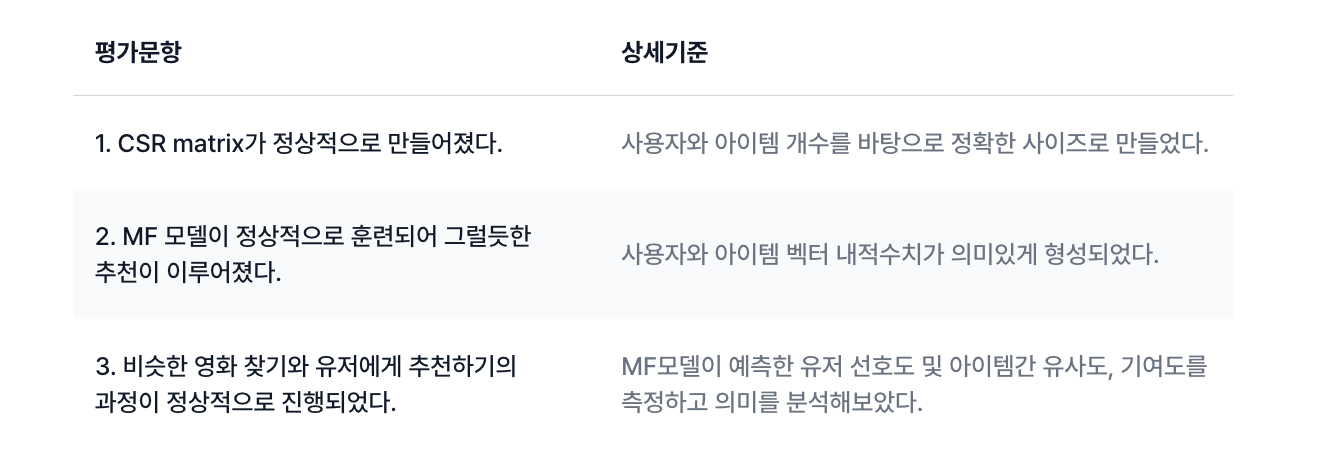

### 12-1. CSR Matrix is created 

    <6040x3628 sparse matrix of type '<class 'numpy.int64'>'

    with 836482 stored elements in Compressed Sparse Row format>

### 12-2. Validated MF Model

    np.dot(v1, v2) 'kenny' vs. 'Matrix, The (1999)': 0.43374157

    np.dot(v1, v3) 'kenny' vs. 'Back to the Future (1985)': 0.5648589

    np.dot(v1, v4) 'kenny' vs. 'Toy Story (1995)': 0.15875658

### 12-3. Similar Movies & Recommendations

    Similar Movies of 'Toy Story (1995)':

        ['Toy Story (1995)',
        'Toy Story 2 (1999)',
        'Aladdin (1992)',
        "Bug's Life, A (1998)",
        'Babe (1995)',
        'Groundhog Day (1993)',
        'Lion King, The (1994)',
        'Pleasantville (1998)',
        'Beauty and the Beast (1991)',
        'There's Something About Mary (1998)']

    Recommendations to 'kenny':
    
        ['Star Wars: Episode V - The Empire Strikes Back (1980)',
        'Star Wars: Episode IV - A New Hope (1977)',
        'Godfather, The (1972)',
        'Godfather: Part II, The (1974)',
        'Star Wars: Episode I - The Phantom Menace (1999)',
        'Terminator 2: Judgment Day (1991)',
        'Jurassic Park (1993)',
        'Forrest Gump (1994)',
        'Raiders of the Lost Ark (1981)',
        'Men in Black (1997)',
        'Terminator, The (1984)',
        '2001: A Space Odyssey (1968)',
        'Saving Private Ryan (1998)',
        'Sixth Sense, The (1999)',
        'Total Recall (1990)',
        'Princess Bride, The (1987)',
        'E.T. the Extra-Terrestrial (1982)',
        'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
        'Moonstruck (1987)',
        'Alien (1979)']